# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# create a Spark session
from pyspark.sql import SparkSession


In [3]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum,max,avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime

import datetime

from pyspark.sql import Window
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import re
from pyspark.sql import functions as sF
from pyspark.sql import types as sT

from functools import reduce


from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df = spark.read.json("mini_sparkify_event_data.json")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



* Artist: The artist being listened to
* Auth: Whether or not the user is logged in
* FirstName: First name of the user
* Gender: Gender of the user
* ItemInSession: Item number in session
* LastName: Last name of the user
* Length: Length of time for specific log
* Level: Free or Paid user
* Location: Physical location of user
* Method: Get or Put requests (Web calls)
* Page: Which page are they on in the site
* Registration: Users registration number
* SessionId: Session ID
* Song: Song currently being played
* Status: Web status (200 for OK, etc.)
* Ts: Timestamp of current log
* UserAgent: Type of browser user is on
* UserId: UserID for user

In [7]:
df.count()

286500

In [8]:
df=df.dropna(subset=["userId","sessionId"],how="any")

In [9]:
df.count()

286500

In [10]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [11]:
df=df.filter(df["userId"] != "")

In [12]:
df.count()

278154

In [13]:
df.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [14]:
df.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



In [15]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           278154|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|               10|
|    max|               99|
+-------+-----------------+



In [16]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [17]:
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Define Churn


* In this application we have total 19 pages as shown below:

In [18]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



* I am using the Cancellation Confirmation  events to define churn as target

In [15]:
# Churn is a label for user who cancelled
# Define a flag function
df_churn_flag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply to the dataframe
df_churned = df.withColumn("churned", df_churn_flag("page"))

In [16]:
#Define window bounds
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df_phase = df_churned.withColumn("phase", sum('churned').over(windowval))
df_churn = df_phase.withColumn("churn", max('churned').over(Window.partitionBy("userId")))

In [17]:
df_churn.select(["userId", "gender", "level", "page", "status", "ts", "churn", "phase", "churned"]).show(20)

+------+------+-----+-----------+------+-------------+-----+-----+-------+
|userId|gender|level|       page|status|           ts|churn|phase|churned|
+------+------+-----+-----------+------+-------------+-----+-----+-------+
|100010|     F| free|   NextSong|   200|1539003534000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539003736000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539003932000|    0|    0|      0|
|100010|     F| free|  Thumbs Up|   307|1539003933000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539004195000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539004511000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539004694000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539004918000|    0|    0|      0|
|100010|     F| free|Roll Advert|   200|1539004961000|    0|    0|      0|
|100010|     F| free|   NextSong|   200|1539005157000|    0|    0|      0|
|100010|     F| free|   N

In [18]:
df_churn.filter(df_churn["churn"] == 1).select(["userId", "gender", "level", "page", "status", "ts", "churn", "phase", "churned"]).show(20)

+------+------+-----+--------------------+------+-------------+-----+-----+-------+
|userId|gender|level|                page|status|           ts|churn|phase|churned|
+------+------+-----+--------------------+------+-------------+-----+-----+-------+
|   125|     M| free|            NextSong|   200|1539317144000|    1|    0|      0|
|   125|     M| free|            NextSong|   200|1539317481000|    1|    0|      0|
|   125|     M| free|            NextSong|   200|1539317711000|    1|    0|      0|
|   125|     M| free|            NextSong|   200|1539317914000|    1|    0|      0|
|   125|     M| free|            NextSong|   200|1539318124000|    1|    0|      0|
|   125|     M| free|            NextSong|   200|1539318515000|    1|    0|      0|
|   125|     M| free|            NextSong|   200|1539318728000|    1|    0|      0|
|   125|     M| free|            NextSong|   200|1539318906000|    1|    0|      0|
|   125|     M| free|         Roll Advert|   200|1539318917000|    1|    0| 

In [19]:
churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()
print("churned user count: {} (total: {})".format(churned_user_count, df_churn.count()))
print("churned user rate: {:.2f}%".format(churned_user_count / df_churn.count() * 100))

churned user count: 52 (total: 278154)
churned user rate: 0.02%


# Explore Data

In [20]:
# Let's know the number of users in this dataset and the number of pages and sessions

[f'Unique {col}s: {df.select(col).dropDuplicates().count()}' for col in ('userId', 'page', 'sessionId')]

['Unique userIds: 225', 'Unique pages: 19', 'Unique sessionIds: 2312']

* Explore the values of  categoric and numeracial columns

In [21]:
num_cols = []
cat_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        cat_cols.append(s.name)
    
    if data_type == "LongType" or data_type == "DoubleType":
        num_cols.append(s.name)

In [22]:
num_cols

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [23]:
cat_cols

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

In [24]:
df.describe(num_cols).show()

+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|           length|        registration|         sessionId|            status|                  ts|
+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|  count|            278154|           228108|              278154|            278154|            278154|              278154|
|   mean|114.89918174824018|249.1171819778458|1.535358834084427...|1042.5616241362698|209.10321620397335|1.540958915431871...|
| stddev|  129.851729399489|99.23517921058361| 3.291321616327586E9| 726.5010362219813|30.151388851328214|1.5068287123306298E9|
|    min|                 0|          0.78322|       1521380675000|                 1|               200|       1538352117000|
|    max|              1321|       3024.66567|       1543247354000|              2474|               404|      

In [25]:
df.select("status").drop_duplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



* Explore the values of some categoric columns 

In [26]:
df.select("gender").dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [27]:
df.select("location").dropDuplicates().show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



In [28]:
df.select("page").drop_duplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [29]:
#define pandas df for better view
dfp=df_churn.toPandas()

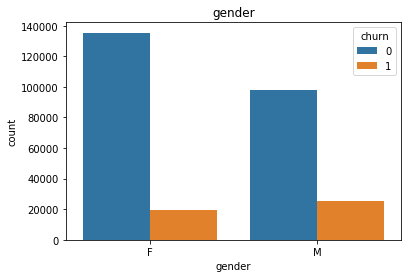

In [30]:
sns.countplot(x="gender", hue="churn", data=dfp).set_title("gender");


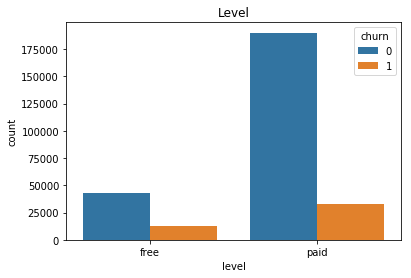

In [31]:
sns.countplot(x="level", hue="churn", data=dfp).set_title("Level");

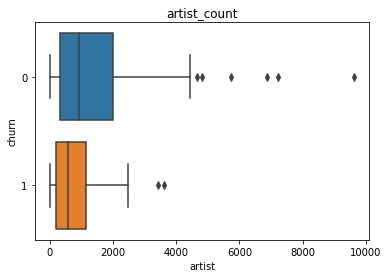

In [32]:

df_artist = pd.DataFrame(dfp.groupby(["churn", "userId"])['artist'].size()).reset_index()



sns.boxplot(x='artist', y='churn', orient="h", data=df_artist).set_title("artist_count");

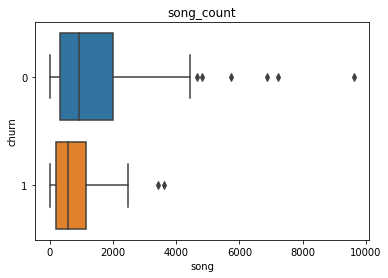

In [33]:
df_song = pd.DataFrame(dfp.groupby(["churn", "userId"])['song'].size()).reset_index()



sns.boxplot(x='song', y='churn', orient="h", data=df_song).set_title("song_count");

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [34]:
user_artist = df_churn.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")
user_artist.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|100010|         275|
|200002|         387|
|   125|           8|
|    51|        2111|
|   124|        4079|
+------+------------+
only showing top 5 rows



* we have selected the gender as the first feature for our analysis

In [35]:
flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
df_churn_with_gender = df_churn.withColumn("gender", flag_gender("gender"))
user_gender = df_churn_with_gender.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|100010|     1|
|200002|     0|
|   125|     0|
|    51|     0|
|   124|     1|
+------+------+
only showing top 5 rows



* we have created feature which holds the sum lenght by users.

In [36]:
user_length = df_churn.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")
user_length.show(5)

+------+------------------+
|userId|            length|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows



* Thumbs up: This features hold the count of users who has gave thumbs up.

In [37]:
user_thumbs_up = df_churn.filter(df_churn["page"] == 'Thumbs Up').groupby('userId').count().withColumnRenamed("count", "thumb_up")
user_thumbs_up.show(5)

+------+--------+
|userId|thumb_up|
+------+--------+
|100010|      17|
|200002|      21|
|    51|     100|
|   124|     171|
|     7|       7|
+------+--------+
only showing top 5 rows



* Thumbs down: This features hold the count of users who has gave thumbs down

In [38]:
user_thumbs_down = df_churn.filter(df_churn["page"] == 'Thumbs Down').groupby('userId').count().withColumnRenamed("count", "thumb_down")
user_thumbs_down.show(5)

+------+----------+
|userId|thumb_down|
+------+----------+
|100010|         5|
|200002|         6|
|    51|        21|
|   124|        41|
|     7|         1|
+------+----------+
only showing top 5 rows



* we have created feature which holds the count of songs played by users.

In [39]:
user_song = df_churn.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")
user_song.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|100010|       275|
|200002|       387|
|   125|         8|
|    51|      2111|
|   124|      4079|
+------+----------+
only showing top 5 rows



* we have created feature which holds the max level played by users.

In [40]:
flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
df_churn_with_level = df_churn.withColumn("level", flag_level("level"))
user_level = df_churn_with_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
user_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|    51|    1|
|   124|    1|
+------+-----+
only showing top 5 rows



In [41]:
df_original = df_churn.groupby('userId').max("churn").withColumnRenamed("max(churn)", "target")
df_original.show(5)

+------+------+
|userId|target|
+------+------+
|100010|     0|
|200002|     0|
|   125|     1|
|   124|     0|
|    51|     1|
+------+------+
only showing top 5 rows



* After merging all the features into one variable, lets see few records records how it looks:

In [42]:
merged_df = df_original.join(user_artist, ['userId']) \
    .join(user_gender, ['userId']) \
    .join(user_length, ['userId']) \
    .join(user_level, ['userId']) \
    .join(user_thumbs_up, ['userId']) \
    .join(user_thumbs_down, ['userId']) \
    .join(user_song, ['userId'])

In [43]:
merged_df.show(5)

+------+------+------------+------+------------------+-----+--------+----------+----------+
|userId|target|artist_count|gender|            length|level|thumb_up|thumb_down|song_count|
+------+------+------------+------+------------------+-----+--------+----------+----------+
|100010|     0|         275|     1| 66940.89735000003|    0|      17|         5|       275|
|200002|     0|         387|     0| 94008.87593999993|    1|      21|         6|       387|
|    51|     1|        2111|     0| 523275.8428000004|    1|     100|        21|      2111|
|   124|     0|        4079|     1|1012312.0927899999|    1|     171|        41|      4079|
|     7|     0|         150|     0| 38034.08710000002|    0|       7|         1|       150|
+------+------+------------+------+------------------+-----+--------+----------+----------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

* Drop userId column (which is not necessary for modeling)

In [44]:
df_final = merged_df.drop("userId")
feature_columns = [col for col in df_final.columns if col!='target']
feature_columns

['artist_count',
 'gender',
 'length',
 'level',
 'thumb_up',
 'thumb_down',
 'song_count']

   Build model

In [48]:
def build_model(classifier, param):
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='target', metricName='f1'),
        numFolds=5,
    )
    return model

In [49]:
train, test = df_final.randomSplit([0.7, 0.3], seed=0)

# Logistic Regression

In [50]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="target")
param = ParamGridBuilder().build()
model = build_model(lr, param)

In [51]:
%%time
fit_model = model.fit(train)

CPU times: user 8.26 s, sys: 3.04 s, total: 11.3 s
Wall time: 12min 37s


In [52]:
pred = fit_model.transform(test)

In [53]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target")
f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
print("f1: {}".format(f1_score))

f1: 0.7324641460234681


# Random Forest

In [54]:
rf =RandomForestClassifier(featuresCol="scaled_features", labelCol="target")
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)

In [55]:
%%time
rf_fit_model = rf_model.fit(train)

CPU times: user 3.35 s, sys: 1.11 s, total: 4.46 s
Wall time: 6min 56s


In [56]:
rf_pred = rf_fit_model.transform(test)

rf_f1_score = evaluator.evaluate(rf_pred, {evaluator.metricName: "f1"})

print("f1: {}".format(rf_f1_score))

f1: 0.716976127320955


In [59]:
rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df['feature'] = feature_columns
rf_feature_importance_df['importance'] = rf_fit_model.bestModel.stages[2].featureImportances.values.tolist()
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_feature_importance_df

,feature,importance
0,thumb_up,0.240148
1,artist_count,0.211432
2,thumb_down,0.199641
3,song_count,0.154187
4,length,0.089913
5,gender,0.062776
6,level,0.041904


* According to the feature importances provided by the Random Forest model, Thumbs Up and Thumbs Down seem to be important while the level of the users do not really matter

# GBT

In [254]:
gbt =GBTClassifier(featuresCol="scaled_features", labelCol="target")
gbt_param = ParamGridBuilder().build()
gbt_model = build_model(gbt, gbt_param)

In [255]:
%%time
gbt_fit_model = gbt_model.fit(train)

CPU times: user 32.1 s, sys: 7.19 s, total: 39.3 s
Wall time: 40min 53s


In [256]:
gb_pred = gbt_fit_model.transform(test)

gb_f1_score = evaluator.evaluate(gb_pred, {evaluator.metricName: "f1"})

print("f1: {}".format(gb_f1_score))

f1: 0.7215309200603317


# Conclusion


* We can choose few other models and compare the results with Logistic Regression. Which one gives the best result should be picked as our model.
 
 * to improve the current implementation ;
 * 1-Trying more parameters of the selected models.
 * 2- Adding some more features that I believe essential, like the customer location (city/state). The customers of some states appear to have more ability to churn than others; this might be attributed to the nature of life there, some lifestyle profiles force people to be rapidly bored, and thus they like to change the services they use, and trying to try other services. On the other hand, peaceful environment make people settled with what they have and resist change.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.